import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Analyze dataset

Load wine dataset and analyze it. The goal is to understand the features, their values and the labels.

In [261]:
import pandas as pd
dataset = pd.read_csv('./datasets/winequality-white.csv',sep=';')

Set specific random seed to be able to reproduce results

In [262]:
import numpy as np
np.random.seed(42)

Wine dataset contains 11 numeric features and an integer label column (quality).

In [263]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Although wine labels vary from 1-9, we only see 7 values. Therefore the labels that we have are only 7 - not 9.

In [264]:
print(f'Labels: {sorted(dataset.quality.unique())}')
print(f'Label count: {len(dataset.quality.unique())}')
print(f'Min label: {dataset.quality.min()}')
print(f'Max label: {dataset.quality.max()}')

Labels: [3, 4, 5, 6, 7, 8, 9]
Label count: 7
Min label: 3
Max label: 9


We see that the features have very different scales, and therefore it should be useful to scale them.

In [265]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Also, a good thing is that the dataset does not contain null values.

In [266]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We see that most of the wines have quality scores 5-9. There are no wines with quality less than 3 or equal to 10.

<Figure size 432x288 with 0 Axes>

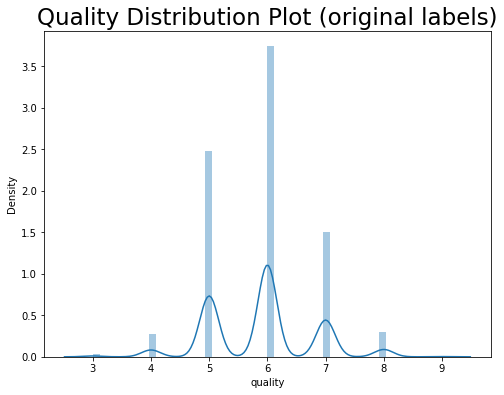

quality
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
dtype: float64

In [267]:
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

plt.set_cmap('tab10')
sns.set_palette('tab10')

warnings.filterwarnings('ignore')

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (original labels)',fontsize=23)
sns.distplot(dataset['quality'])
plt.show()

dataset.groupby('quality').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

As we don't have a good distribution of labels, we will reduce their number. Let's try to reduce the labels' number to 3:
- 0 if quality is less or equal to 5
- 1 if quality is equal to 6
- 2 if quality is greater than 6.

We see that we have a much better distribution of wines to labels.

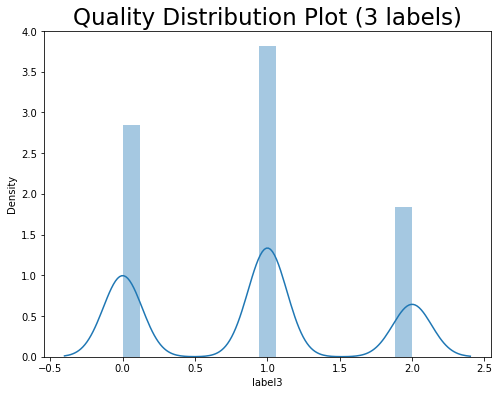

label3
0    0.334831
1    0.448755
2    0.216415
dtype: float64

In [268]:
dataset['label3'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else (1 if row['quality'] == 6 else 2), axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (3 labels)',fontsize=23)
sns.distplot(dataset['label3'])
plt.show()

dataset.groupby('label3').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

Last but not least, let's try to reduce the label's number to 2:
- 0 if quality is less or equal to 5
- 1 if quality is greater or equal to 6

We see that we have a more uneven distribution. Maybe it is better to keep the 3 labels.

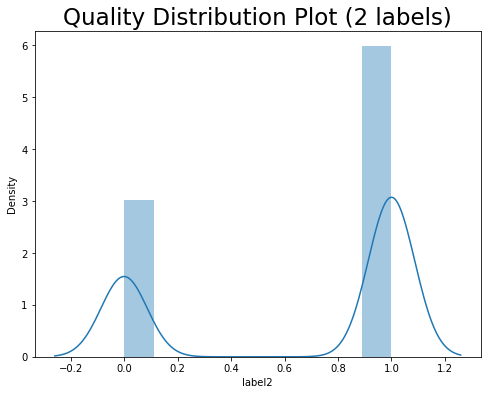

label2
0    0.334831
1    0.665169
dtype: float64

In [269]:
dataset['label2'] = dataset.apply(lambda row: 0 if row['quality'] <=5 else 1, axis=1)

_, _ = plt.subplots(figsize=(8, 6))
plt.title('Quality Distribution Plot (2 labels)',fontsize=23)
sns.distplot(dataset['label2'])
plt.show()

dataset.groupby('label2').size().groupby(level=0).apply(lambda row: row / len(dataset.index))

# 2. kMeans Clustering and hyperparameters tuning
I performed kMeans clustering on the wine dataset and I used grid search in order to find the best value for cluster size and initialization method. I tested cluster sizes from 1 to 30 and k-means++ and random initialization methods.

Before runnging kMeans clustering, I scaled the data and I separated the features from the labels.

In [270]:
from sklearn.preprocessing import StandardScaler


features = dataset.drop(['quality', 'label2', 'label3'], axis=1)
feature_names = features.columns
features = StandardScaler().fit_transform(features)
features = pd.DataFrame(features, columns=feature_names)

labels_2 = dataset['label2']
labels_3 = dataset['label3']
labels_7 = dataset['quality']

Then I performed grid search in order to find the appropriate k and init method for the kMeans algorithm.

I evaluated kMeans performance using the following:
- The Elbow method
- Silhouette Score
- Homogenity / Completeness agains true labels for the case of 2, 3 and 7 labels.

In [271]:
from tqdm.notebook import tqdm
from time import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics

n_clusters_values = range(1, 31)
init_values = ['k-means++', 'random']

progress_bar = tqdm(total=len(n_clusters_values) * len(init_values))
wcss = {init:[] for init in init_values}
silhouette_score = {init:[] for init in init_values}
fit_time = {init:[] for init in init_values}
v_measure_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
homogeneity_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
completeness_score = {
    'labels_2': {init:[] for init in init_values},
    'labels_3': {init:[] for init in init_values},
    'labels_7': {init:[] for init in init_values},
}
for init in init_values:
    for n_clusters in n_clusters_values:
        results = {}
        kmeans = KMeans(n_clusters=n_clusters,
                        init=init, random_state=42)
        t0 = time()
        kmeans.fit(features)
        fit_time[init].append(time() - t0)
        wcss[init].append(kmeans.inertia_)
        silhouette_score[init].append(None if n_clusters == 1 else metrics.silhouette_score(features,
                                                                                            kmeans.labels_,
                                                                                            metric="euclidean",
                                                                                            sample_size=300,
                                                                                            random_state=42))
        v_measure_score['labels_2'][init].append(metrics.v_measure_score(
            labels_2, kmeans.labels_))
        v_measure_score['labels_3'][init].append(metrics.v_measure_score(
            labels_3, kmeans.labels_))
        v_measure_score['labels_7'][init].append(metrics.v_measure_score(
            labels_7, kmeans.labels_))
        homogeneity_score['labels_2'][init].append(metrics.homogeneity_score(
            labels_2, kmeans.labels_))
        homogeneity_score['labels_3'][init].append(metrics.homogeneity_score(
            labels_3, kmeans.labels_))
        homogeneity_score['labels_7'][init].append(metrics.homogeneity_score(
            labels_7, kmeans.labels_))
        completeness_score['labels_2'][init].append(metrics.completeness_score(
            labels_2, kmeans.labels_))
        completeness_score['labels_3'][init].append(metrics.completeness_score(
            labels_3, kmeans.labels_))
        completeness_score['labels_7'][init].append(metrics.completeness_score(
            labels_7, kmeans.labels_))
        progress_bar.update(1)

  0%|          | 0/60 [00:00<?, ?it/s]

I wrote a useful method to plot graphs.

In [272]:
def plot_clustering_metrics(ax, title, y_axis, x_axis, values, n_clusters_values):
    ax.set_xticks(n_clusters_values)
    for key in values:
        ax.plot(n_clusters_values, values[key])
    ax.set_title(title)
    ax.set(xlabel=x_axis, ylabel=y_axis)
    ax.grid()
    ax.legend(values.keys())

### Selecting the initialization method
As expected, selecting initial centroids using the k-means++ method (as described by Arthur, D. and Vassilvitskii, S. in “k-means++: the advantages of careful seeding paper) did not have any effect in performance. However, the results that I received were in contrast with the ones described in the paper. I did not see any improvement in the performance of the kMeans algorithm. On the contrast, random inialization had lower fit times. I am not aware why this happened. It could be the case that the wine dataset is too small and the performance uplift cannot exceed the k-means++ overhead cost and therefore the total fit time is worse, when compared to random centroid initialization.

In [273]:
K_MEANS_INIT = 'random'

### Selectintg the right cluster number
1. The Elbow Method: Although there is not a perfect "elbow" in the graph, we see that the squared error of the distances of the points from their cluster center rapidly decreases until k=4 (the line is more steep for k=1,2 though).After k=4 the error still decreases, however, at a slower pace. Therefore, it seems that it does not worth to increase the cluster number further as the benefit in error reduction is negligible.
2. The Silhouette Score: I did not expect the results I got from the silhouette score: the score decreases as the number of clusters increases. Silhouette score represents how far is each point from the points of the same cluster vs how far it is from the points of all other clusters. This means that as the clusters increase, the selectd points cannot form clear groups. The best performing silhouette values are for k=2 (~0.2), k=3-6 (~0.14). After k=6 silhouette score drops significantly. One interesting thing is that for larger k values, silhouetter score drops faster for the random initialization method than for the k-means++ initialization method. One explanation for this is because kMeans runs for a limited amount of iterations (I kept default values for n_init and max_iter) for larger number of clusters needs more time to converge. As k-means++ improves convergence time by selecting initial centroids in a more optimal way, it is able to reach convergence sooner, while random might reach the iteration limits with a poorer performance.

In my opinion, graphs indicate k=2-6 as good candidates for cluster sizes. However, one alternative approach in selecting cluster size is to take into consideration the real-world case we are dealing with. As the wine datased is already labeled, why not select a k that corresponds to the label count? As discussed, apart from the 7 quality lablels, I created two extra ways of labeling wines, by combining different labels.
will rely k selection on the Elbow method scores.

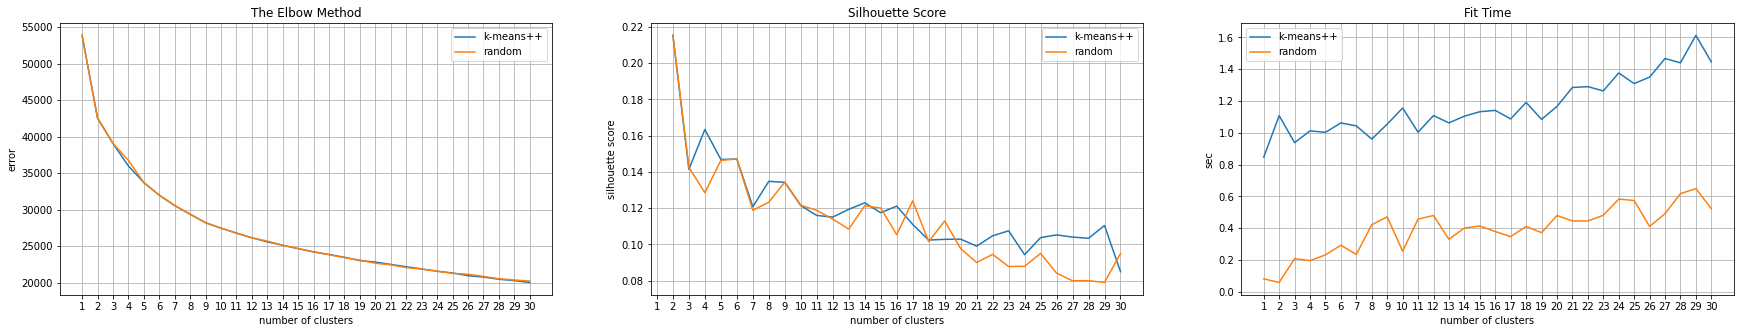

In [274]:
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'The Elbow Method', 'error', 'number of clusters', wcss, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette_score, n_clusters_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of clusters', fit_time, n_clusters_values)

I didn't get the results I expected. I expected to see better performance when using the cluster number matches the number of real labels. I expected to see good performance for k=2 when having only 2 labels, for k=3 when having 3 labels and k=7 when having 7 labels. Instead, I found that performance fluctuations as k changes is the same for all cases, no matter how many labels we have.

What I expected and it actuall happened is that homogeneity score increased as number of clusters increased, which makes sense, as having more clusters means that the probability of having two points of different real label in the same cluster decreases.


Some intersting findings:
- Homogeneity score doubles when moving from 5 to 6 clusters. I am not sure why this happens. Maybe kMeans put most of the points with one of largest labels in population (5-6 quality) in that 6th class and this is the reason why homogeneity score increased that much.
- Completeness score is maximum for k=2 then drops significantly, peacks at k=6 and then it stabilizes. It seems that when having two clusters, there is some (small) consistency in the way real labels are distributed to the clusters. Again, performance peacks at k=6. This indicates that having 6 clusters allows kMeans to better allocate real-world labels to its clusters. Even if the number of clusters increase, there is no impact on completeness.
- When using 2 labels, we achieve the highest homogeineity scores, but the worse completeness scores, no matter the cluster count. On the contrast, when using 7 labels we achieve the highest completeness score but the worse homogeneity scores. This is strange and I believe is affected by luck and randomness. The performance of kMeans is very poor (both homgeneity and completeness scores are too low).

From the comparizon to real labels, it seems that k=6 is the best choice for k, which is close to the 7 labels we have in the datase.

Thus, although the Elbow/Silhouette analysis would indicate that even smaller values for k would be good options, I decided to use k=6.

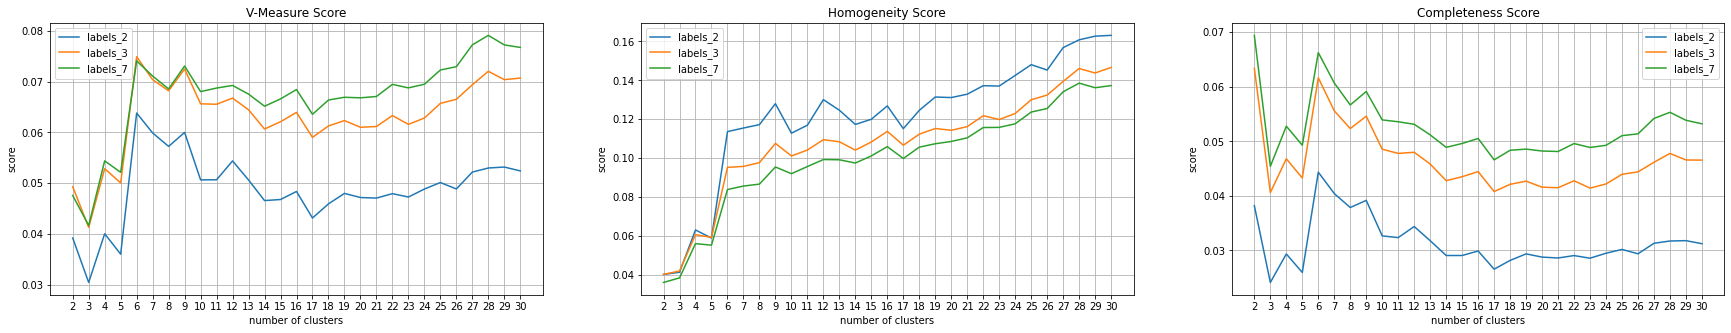

In [275]:
v_measure_score_plot = {label:v_measure_score[label]['random'][1:] for label in v_measure_score.keys()}
homogeneity_score_plot = {label:homogeneity_score[label]['random'][1:] for label in homogeneity_score.keys()}
completeness_score_plot = {label:completeness_score[label]['random'][1:] for label in completeness_score.keys()}
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'V-Measure Score', 'score', 'number of clusters', v_measure_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[1], 'Homogeneity Score', 'score', 'number of clusters', homogeneity_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[2], 'Completeness Score', 'score', 'number of clusters', completeness_score_plot, n_clusters_values[1:])

In [276]:
K_MEANS_CLUSTERS = 6

# 3. Expectation Maximization Clustering and hyperparameters tuning
I performed Expectation Maximization clustering on the wine dataset and I used grid search in order to find the best value for cluster size and initialization method. I tested cluster sizes from 1 to 30 and full, tied, diag, spherical covariance types.

For the case of Expectation Maximization, it does not make sense to use the Elbow method as evaluation criterion, as the points do not belong only to one cluster. Instead I used the Bayesian information criterion (BIC).

In [277]:
from tqdm.notebook import tqdm
from time import time
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn import metrics

n_clusters_values = range(1, 31)
covariance_type_values = ['full', 'tied', 'diag', 'spherical']

progress_bar = tqdm(total=len(n_clusters_values) * len(covariance_type_values))
bic = {covariance_type:[] for covariance_type in covariance_type_values}
silhouette_score = {covariance_type:[] for covariance_type in covariance_type_values}
fit_time = {init:[] for init in covariance_type_values}
v_measure_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
homogeneity_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
completeness_score = {
    'labels_2': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_3': {covariance_type:[] for covariance_type in covariance_type_values},
    'labels_7': {covariance_type:[] for covariance_type in covariance_type_values},
}
for covariance_type in covariance_type_values:
    for n_components in n_clusters_values:
        results = {}
        em = GaussianMixture(n_components=n_components,
                        covariance_type=covariance_type, random_state=42)
        t0 = time()
        em.fit(features)
        fit_time[covariance_type].append(time() - t0)
        labels_ = em.predict(features)
        bic[covariance_type].append(em.bic(features))
        silhouette_score[covariance_type].append(None if n_components == 1 else metrics.silhouette_score(features,
                                                                                            labels_,
                                                                                            metric="euclidean",
                                                                                            sample_size=300))
        v_measure_score['labels_2'][covariance_type].append(metrics.v_measure_score(
            labels_2, labels_))
        v_measure_score['labels_3'][covariance_type].append(metrics.v_measure_score(
            labels_3, labels_))
        v_measure_score['labels_7'][covariance_type].append(metrics.v_measure_score(
            labels_7, labels_))
        homogeneity_score['labels_2'][covariance_type].append(metrics.homogeneity_score(
            labels_2, labels_))
        homogeneity_score['labels_3'][covariance_type].append(metrics.homogeneity_score(
            labels_3, labels_))
        homogeneity_score['labels_7'][covariance_type].append(metrics.homogeneity_score(
            labels_7, labels_))
        completeness_score['labels_2'][covariance_type].append(metrics.completeness_score(
            labels_2, labels_))
        completeness_score['labels_3'][covariance_type].append(metrics.completeness_score(
            labels_3, labels_))
        completeness_score['labels_7'][covariance_type].append(metrics.completeness_score(
            labels_7, labels_))
        progress_bar.update(1)

  0%|          | 0/120 [00:00<?, ?it/s]

Full covariance method achieved the lowest BIC and the worse Silhouette score, while Spherical covariance tye had the worse BIC and the best silhouette score. It seems that full covariance method makes the model exlain the data better than the other models or it is simpler than the other models.

For that reason I selected the full covariance type.

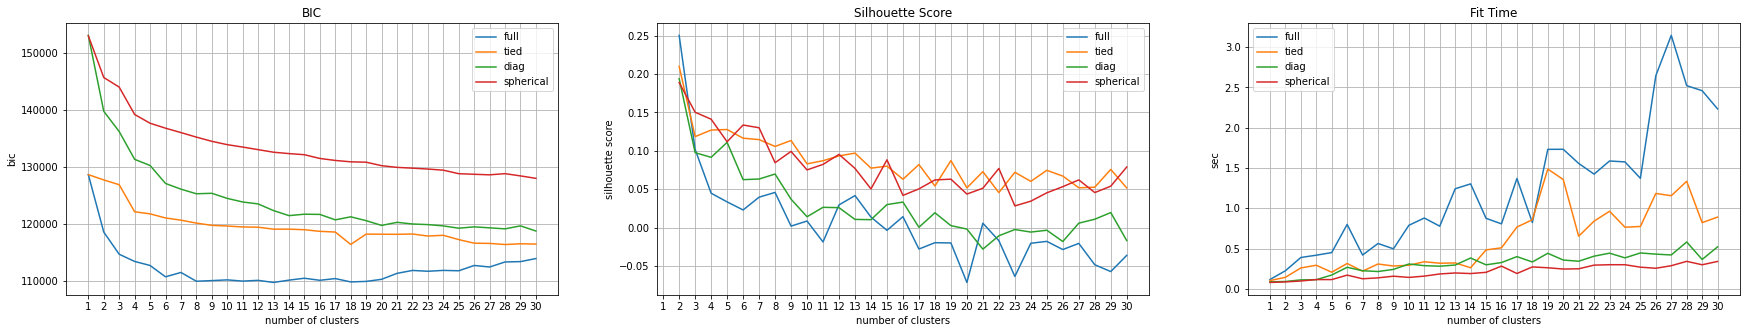

In [278]:
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'BIC', 'bic', 'number of clusters', bic, n_clusters_values)
plot_clustering_metrics(ax[1], 'Silhouette Score', 'silhouette score', 'number of clusters', silhouette_score, n_clusters_values)
plot_clustering_metrics(ax[2], 'Fit Time', 'sec', 'number of clusters', fit_time, n_clusters_values)

In [279]:
EM_COVARIANCE_TYPE = 'full'

When lookion on how well the model classifies data against the real labels, the performance is similar to the kMeans clustering. Value of k=7 seems to be a good choice, as after this the benefits are minimal (in terms of good classification).

Thus, I selected k=7 as the number of clusters/gaussian centers for the EM algorithm.

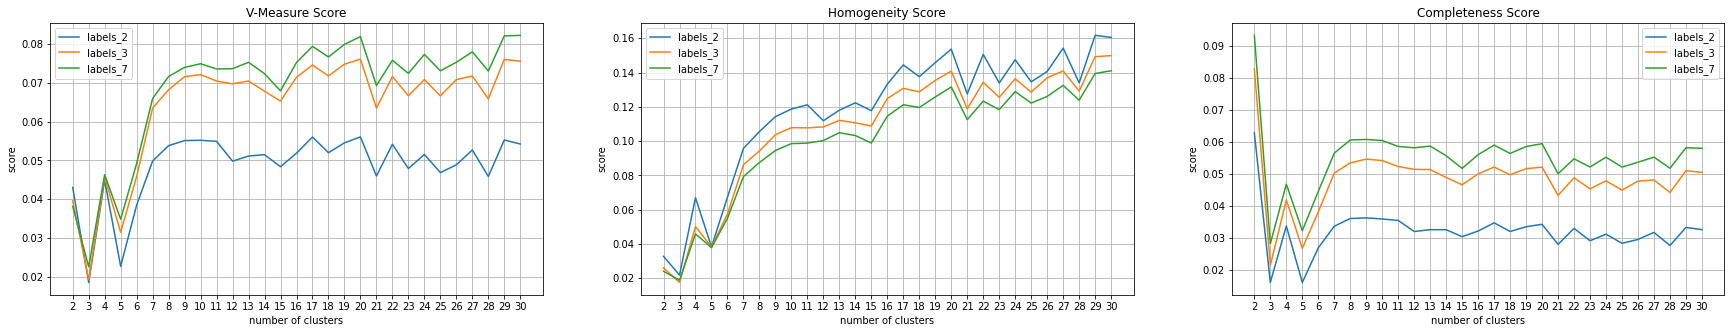

In [280]:
v_measure_score_plot = {label:v_measure_score[label][EM_COVARIANCE_TYPE][1:] for label in v_measure_score.keys()}
homogeneity_score_plot = {label:homogeneity_score[label][EM_COVARIANCE_TYPE][1:] for label in homogeneity_score.keys()}
completeness_score_plot = {label:completeness_score[label][EM_COVARIANCE_TYPE][1:] for label in completeness_score.keys()}
_, ax = plt.subplots(1, 3, figsize=(30, 5))
plot_clustering_metrics(ax[0], 'V-Measure Score', 'score', 'number of clusters', v_measure_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[1], 'Homogeneity Score', 'score', 'number of clusters', homogeneity_score_plot, n_clusters_values[1:])
plot_clustering_metrics(ax[2], 'Completeness Score', 'score', 'number of clusters', completeness_score_plot, n_clusters_values[1:])

In [281]:
EM_CLUSTERS = 7

Do my clustering algorithms perform well? I doubpt. The poor clustering results can also be partially verified when the 11 features of the dataset are projected to 2 dimensions: there is no clear separation of the real labels of the dataset.

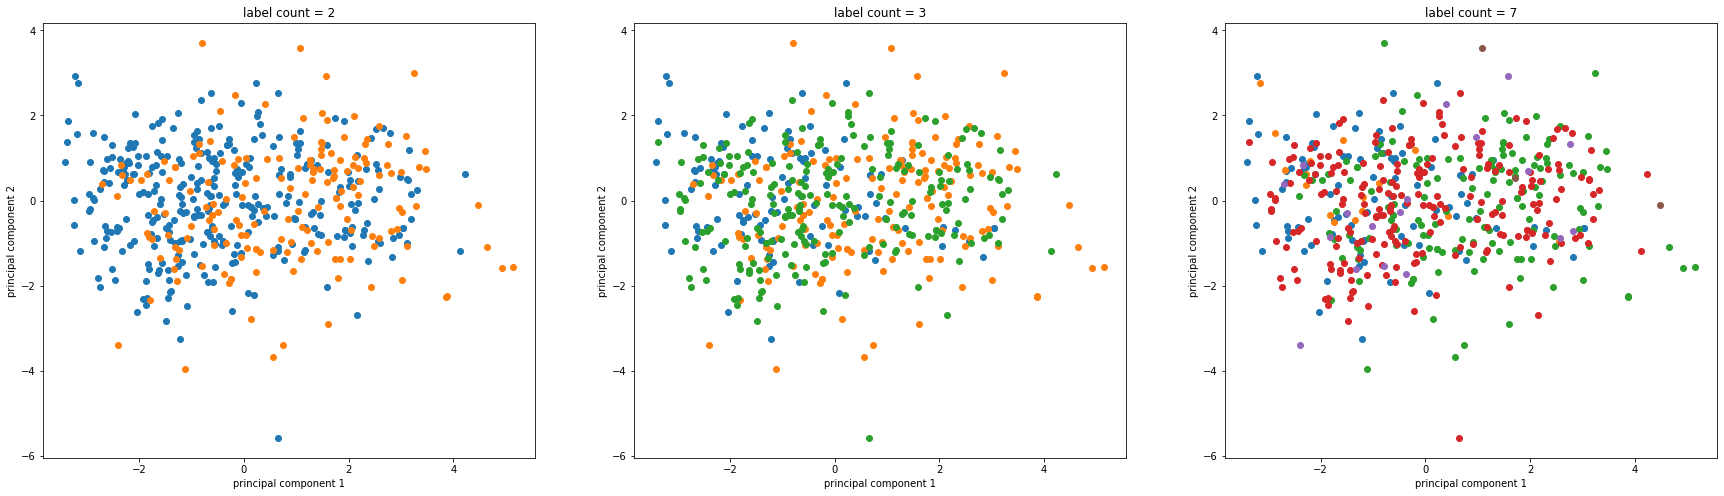

In [282]:
from sklearn.decomposition import PCA
np.random.seed(42)

pca_2d = PCA(n_components=2, random_state=42)
principal_components_2d = pca_2d.fit_transform(features)
principal_components_2d = pd.DataFrame(principal_components_2d, columns=[
                                       'principal component 1', 'principal component 2'])
principal_components_2d['label_2'] = labels_2
principal_components_2d['label_3'] = labels_3
principal_components_2d['label_7'] = labels_7

_, ax = plt.subplots(1, 3, figsize=(30, 8))
principal_components_2d = principal_components_2d.sample(500)
label_types = ['label_2', 'label_3', 'label_7']
for index, label in enumerate(label_types):
    ax[index].set(xlabel='principal component 1', ylabel='principal component 2')
    ax[index].set_title(' count = '.join(label.split("_")))
    for value in principal_components_2d[label].unique():
        indices_to_keep = principal_components_2d[label] == value
        ax[index].scatter(principal_components_2d.loc[indices_to_keep, 'principal component 1'],
                    principal_components_2d.loc[indices_to_keep, 'principal component 2'])
plt.show()


### 4. Dimensionality Reduction

Then, I performed dimensionality reduction using PCA. The basic metric I used to evaluate the resuls was the retained variance. I performed PCA for different values of retained variance (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99) and I monitored the number of principal components as well as the mean squared error between the original features and the re-constructed features after the transformation.
The results were as expected: The more the dimensions are reduced, the more the error increases and the retained variance decreases.

One interesting finding was that reducing the components by 1 has almost zero impact in the quality of the data (mse~=0.002). Even in the case where dimensions are reduced by 2 or 3 (which corresponds to 95% and 90% of retained variance) mse is very low (less than 0.1).

In order to make sure that dimensionality reduction will not have a negative impact in accuracy, I chose n_components=8 as the number of reduced dimensions.

,number of principal components,mse,variance retained
0,1,0.707068,0.20
1,2,0.563864,0.40
2,3,0.452803,0.50
3,4,0.360210,0.60
4,5,0.271725,0.70
5,6,0.186385,0.80
6,7,0.120331,0.85
7,8,0.065844,0.90
8,9,0.028194,0.95
9,10,0.001877,0.99


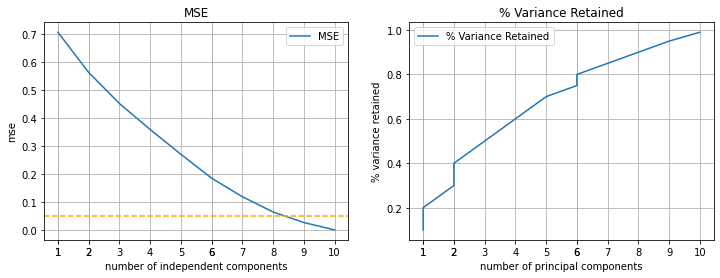

In [283]:
from sklearn.decomposition import PCA

variance_retained_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
pca_mse = []
n_components = []
for variance_retained in variance_retained_values:
    pca = PCA(n_components=variance_retained,
              svd_solver='full', random_state=42)
    principal_components = pca.fit_transform(features)
    n_components.append(np.shape(principal_components)[1])
    reconstructed_features = pca.inverse_transform(principal_components)
    mse = np.mean((np.square(reconstructed_features - features).mean(axis=0)))
    pca_mse.append(mse)

_, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_clustering_metrics(ax[0], 'MSE', 'mse', 'number of independent components', {'MSE': pca_mse}, n_components)
ax[0].axhline(0.05, linestyle='--', color='orange')
plot_clustering_metrics(ax[1], '% Variance Retained', '% variance retained', 'number of principal components', {'% Variance Retained': variance_retained_values}, n_components)

pca_measurements = pd.DataFrame({'mse': pca_mse, 'variance retained': variance_retained_values, 'number of principal components': n_components}).groupby('number of principal components').max('variance retained').reset_index().sort_values('number of principal components')
pca_measurements

In [284]:
PCA_COMPONENTS = int(pca_measurements[pca_measurements.mse < 0.1].iloc[0,:]['number of principal components'])

print(f'Number of principal components selected: {PCA_COMPONENTS}')


Number of principal components selected: 8


Then, I performed dimensionality reduction using ICA. The basic metric I used to evaluate the resuls was kurtosis. I performed ICA for different number of independent components and I monitored the difference of mean kurtosis vs the mean kurtosis of the original dataset as well as the mean squared error between the original features and the re-constructed features after the transformation.
As far as the error is concerned, the results were as expected: the more the dimensions are reduced, the more the error increases.
What was impressive was kurtosis. The kurtosis of independend components matches the original distribution's kurtosis for component values 6-8 and not higher. Also, there is a peak of kurtosis when components=11. I believe that this is a random mistake due to the fact that kurtosis is very sensitive to outliers. Most probably if I changed the randomness seed there would be an outlier for some other value of number of components. Independent component interpretation confuses me a bit, but from what I understand as we achieve good kurtosis for less components, it means that the initial dataset contains some features that just represent noise and they are not that useful and that can be ignored.

In order to balance between error and kurtosis, I selected n_components=7 as the number of reduced dimensions.

  0%|          | 0/11 [00:00<?, ?it/s]

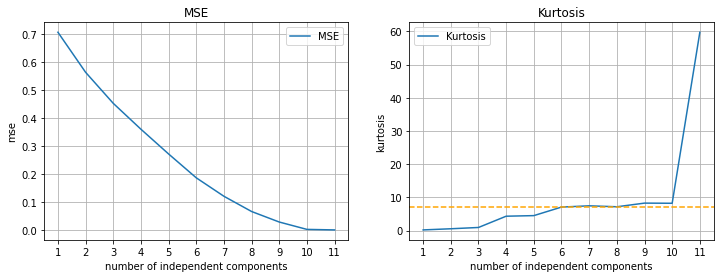

,number of independent components,mse,kurtosis,kurtosis difference from original
0,1,7.070678e-01,0.207054,6.986151
1,2,5.638642e-01,0.553607,6.639599
2,3,4.528032e-01,0.944000,6.249205
3,4,3.602102e-01,4.336309,2.856897
4,5,2.717253e-01,4.514211,2.678994
5,6,1.863851e-01,7.085016,0.108190
6,7,1.203308e-01,7.466978,0.273773
7,8,6.584363e-02,7.180593,0.012612
8,9,2.819420e-02,8.280026,1.086821
9,10,1.877190e-03,8.234091,1.040886


In [311]:
from sklearn.decomposition import FastICA

n_components_values = range(1, features.shape[1] + 1)
ica_mse = []
kurtosis = []
progress_bar = tqdm(total=len(n_components_values))
for n_components in n_components_values:
    ica = FastICA(n_components=n_components, whiten=True, random_state=42)
    independent_components = ica.fit_transform(features)
    reconstructed_features = ica.inverse_transform(independent_components)
    mse = np.mean((np.square(reconstructed_features - features).mean(axis=0)))
    ica_mse.append(mse)
    independent_components = pd.DataFrame(independent_components)
    kurtosis.append(independent_components.kurt(axis=0).abs().mean())
    progress_bar.update(1)

original_kurtosis = pd.DataFrame(features).kurt(axis=0).abs().mean()
_, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_clustering_metrics(ax[0], 'MSE', 'mse', 'number of independent components', {'MSE':ica_mse}, n_components_values)
plot_clustering_metrics(ax[1], 'Kurtosis', 'kurtosis', 'number of independent components', {'Kurtosis':kurtosis}, n_components_values)
ax[1].axhline(original_kurtosis, linestyle='--', color='orange')
plt.show()

ica_measurements = pd.DataFrame({'mse': ica_mse, 'kurtosis': kurtosis, 'number of independent components': n_components_values, 'kurtosis difference from original': np.abs(kurtosis - original_kurtosis)}).groupby('number of independent components').min('kurtosis difference from original').reset_index().sort_values('number of independent components')
ica_measurements

In [312]:
ICA_COMPONENTS = int(ica_measurements[ica_measurements['kurtosis difference from original'] < 0.3].groupby('number of independent components').min('mse').sort_values('mse').reset_index().iloc[0,:]['number of independent components'])
print(f'Number of independent components selected: {ICA_COMPONENTS}')

Number of independent components selected: 8


Then, I performed randomized projection using Sparse Random Projection algorithm in order to reduce the dimensions. As expected, random projections had the worst error when reconstructed the data from the projected components, however, the best performance in terms of time neede to project the components.

In [341]:
from sklearn.random_projection import SparseRandomProjection

n_components_values = range(1, features.shape[1] + 1)

mses = []
density = []
for n_components in n_components_values:
    rp = SparseRandomProjection(n_components=n_components, random_state=42)
    random_components = rp.fit_transform(features)
    transformation_matrix = rp.components_.toarray()
    inverse_transformation_matrix = np.linalg.pinv(transformation_matrix.T)
    reconstructed_features = random_components.dot(inverse_transformation_matrix)
    mses.append(np.mean((np.square(reconstructed_features - features).mean(axis=0))))
    density.append(rp.density_)




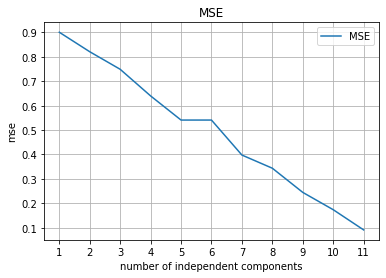

In [342]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_clustering_metrics(ax, 'MSE', 'mse', 'number of independent components', {'MSE':mses}, n_components_values)

Random Projection seems pretty consistend in performance. When running SparseRandomProjection multiple times, the observed variance in MSE is not big. Also, the decreasing trend of the error as components number is increased is consisent accross repetitions. Therefore, it seems a fast and realiable way of reducing dimensions.

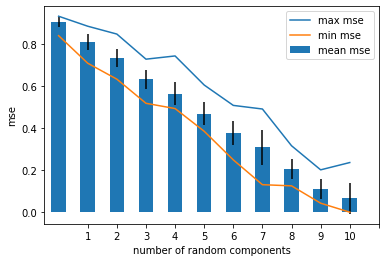

In [343]:
from sklearn.random_projection import SparseRandomProjection

n_components_values = range(1, features.shape[1] + 1)

mses = [[] for _ in n_components_values]
density = []
for _ in range(30):
    for index, n_components in enumerate(n_components_values):
        rp = SparseRandomProjection(n_components=n_components)
        random_components = rp.fit_transform(features)
        transformation_matrix = rp.components_.toarray()
        inverse_transformation_matrix = np.linalg.pinv(transformation_matrix.T)
        reconstructed_features = random_components.dot(inverse_transformation_matrix)
        mses[index].append(np.mean((np.square(reconstructed_features - features).mean(axis=0))))

mse_df = pd.DataFrame(
    {
        'mean mse': [np.mean(mse) for mse in mses],
        'max mse': [np.max(mse) for mse in mses],
        'min mse': [np.min(mse) for mse in mses],
        'mse std': [np.std(mse) for mse in mses]

    }
)
_, ax = plt.subplots(1, 1, figsize=(6, 4))
mse_df['mean mse'].plot.bar(ax=ax, yerr=mse_df['mse std'])
mse_df['max mse'].plot(ax=ax)
mse_df['min mse'].plot(ax=ax)
ax.set_xticks(range(1, features.shape[1] + 1))
ax.set_xlabel('number of random components')
ax.set_ylabel('mse')
ax.legend()
plt.show()

In order to keep transformation metric as small as possible, I chose to use 8 random components.

In [344]:
RANDOM_PROJECTION_COMPONENTS = 9

Last but not least, I tested a totally different approach in reducing dimensions: Use an ensemble of Decision Trees and keep only the important features that the trees used.
For that purpose I used an AdaBoost Classifier, with 100 Decision trees of max-height = 1.

Then I trained the classifier using the whole dataset, and I plotted the feature importance as it was given by SKLearn library.


The results were impressive. Some features were classified as much more important than others, with big differences.

I was curious whether Decision Tree ensemble had identified hidden correlations of features with the label column. For that reason I also plotted the correlation of each feature with the labels column. All important features had a high correlation with the quality column. However, the inverse wasn't true. Some features with medium correlation with the quality column weren't at all important for the Decision Tree Ensemble.

I set at threshold at 0.01 feature importance and I selected only the features that had greater future importance than 0.1.

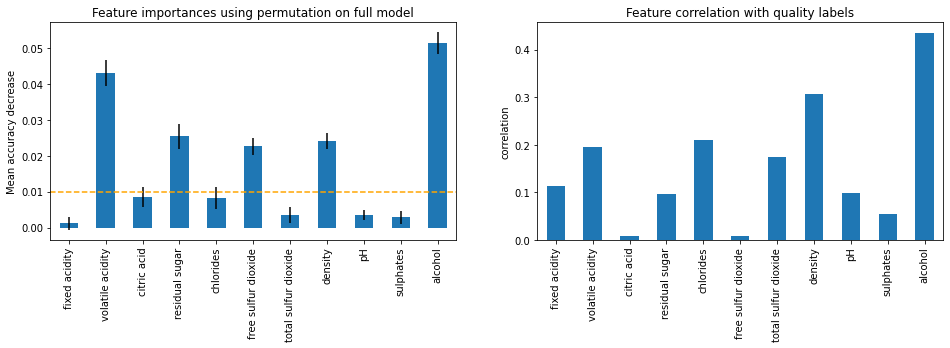

In [345]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance

ensemble = AdaBoostClassifier(n_estimators=100, random_state=42)
ensemble.fit(features, labels_2)

result = permutation_importance(ensemble, features, labels_2, n_repeats=10, random_state=42, n_jobs=2)

feature_importances = pd.Series(result.importances_mean, index=features.columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
feature_importances.plot.bar(yerr=result.importances_std, ax=ax[0])
ax[0].set_title("Feature importances using permutation on full model")
ax[0].set_ylabel("Mean accuracy decrease")
ax[0].axhline(0.01, linestyle='--', color='orange')

ax[1].set_title("Feature correlation with quality labels")
ax[1].set_ylabel("correlation")
feature_correlation = dataset[dataset.columns[:-2]].corr()['quality'].abs()
feature_correlation[feature_correlation.index != 'quality'].plot.bar(ax=ax[1])
plt.show()

In [346]:
import pprint
importances_mean = pd.DataFrame(result.importances_mean, index=features.columns, columns=['importance mean'])
important_features = importances_mean[importances_mean['importance mean'] >= 0.01]
print('Important features based on AdaBoost Classifier:')
pprint.pprint(list(important_features.index), indent=3)
ENSEMBLE_IMPORTANT_FEATURES = list(important_features.index)

Important features based on AdaBoost Classifier:
[  'volatile acidity',
   'residual sugar',
   'free sulfur dioxide',
   'density',
   'alcohol']


Using the reduced dimensions from each Dimensionality Reduction Algorithm, I re-run kMeans and Expectation Maximization and I observed the results.

In [347]:
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(features)
ica = FastICA(n_components=ICA_COMPONENTS, whiten=True, random_state=42)
ica_features = ica.fit_transform(features)
rp = SparseRandomProjection(
    n_components=RANDOM_PROJECTION_COMPONENTS, random_state=42)
rp_features = rp.fit_transform(features)
important_features = features[ENSEMBLE_IMPORTANT_FEATURES].values

transformed_features_list = [features.values, pca_features,
                             ica_features, rp_features, important_features]

feature_count = [len(f[0]) for f in transformed_features_list]
fit_time = np.zeros(len(transformed_features_list))
wcss = []
v_measure_score = []
silhouette_score = []
homogeneity_score = []
completeness_score = []
TIME_TESTS = 20
progress_bar = tqdm(total=len(transformed_features_list) * TIME_TESTS)
kmeans_clustering_labels = []
for iteration in range(TIME_TESTS):
    for index, transformed_features in enumerate(transformed_features_list):
        kmeans = KMeans(n_clusters=K_MEANS_CLUSTERS, init=K_MEANS_INIT, random_state=42)
        t0 = time()
        kmeans.fit(transformed_features)
        kmeans_clustering_labels.append(kmeans.labels_)
        fit_time[index] += time() - t0
        if iteration == 0:
            wcss.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(features,
                                                                kmeans.labels_,
                                                                metric="euclidean",
                                                                sample_size=300))
            v_measure_score.append(metrics.v_measure_score(
                labels_2, kmeans.labels_))

            homogeneity_score.append(metrics.homogeneity_score(
                labels_2, kmeans.labels_))

            completeness_score.append(metrics.completeness_score(
                labels_2, kmeans.labels_))
        progress_bar.update(1)

fit_time = np.divide(fit_time, TIME_TESTS)


  0%|          | 0/100 [00:00<?, ?it/s]

In [348]:
kmeans_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'wcss': wcss,
        'silhouette score': silhouette_score,
        'v measure score': v_measure_score,
        'homogeneity score': homogeneity_score,
        'completeness score': completeness_score,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
kmeans_metrics

,number of components,fit time,wcss,silhouette score,v measure score,homogeneity score,completeness score
original,11,0.245338,31971.457874,0.150048,0.063801,0.113664,0.044346
PCA,8,0.280325,28666.628604,0.131905,0.058391,0.104254,0.040552
ICA,8,0.171292,5.317382,0.133587,0.038340,0.069029,0.026540
Random Projection,9,0.244014,21751.553280,0.087407,0.064448,0.118558,0.044251
Important Features,5,0.201368,9248.049158,0.079801,0.059572,0.110773,0.040741


From the results, I was impressed by the performance of the "Decision Tree" dimensionality reduction. It achieved same performance as Random Projection using just 5 features instead of 8! Although it had the worse Silhouette score, it achieved the lowest in cluster variance compared to all other algorithms (except ICA which was an exception).
Also, in terms of classification against the real labels, it performed as well as Random Projection and PCA.

This makes me think that indeed some features of the wine dataset were much related to the quality of the wine and therefore, the other features were just adding noise.

ICA showed a very small variance and I believe this is a false metric. Most probably SKLearn ICA algorithm performed some pre-processing on the data and therefore it changed the scale. Thus, I cannot comment on the variance of ICA.

In any case it seems that the projections that PCA and ICA made are not much meaningfull as they did not provide any benefit to the algorithm.

I was also impressed (and disappointed) about the negative impact that PCA had on performance. I would expect it to speed up fitting time not to worsen it. I cannot explain why this happened.

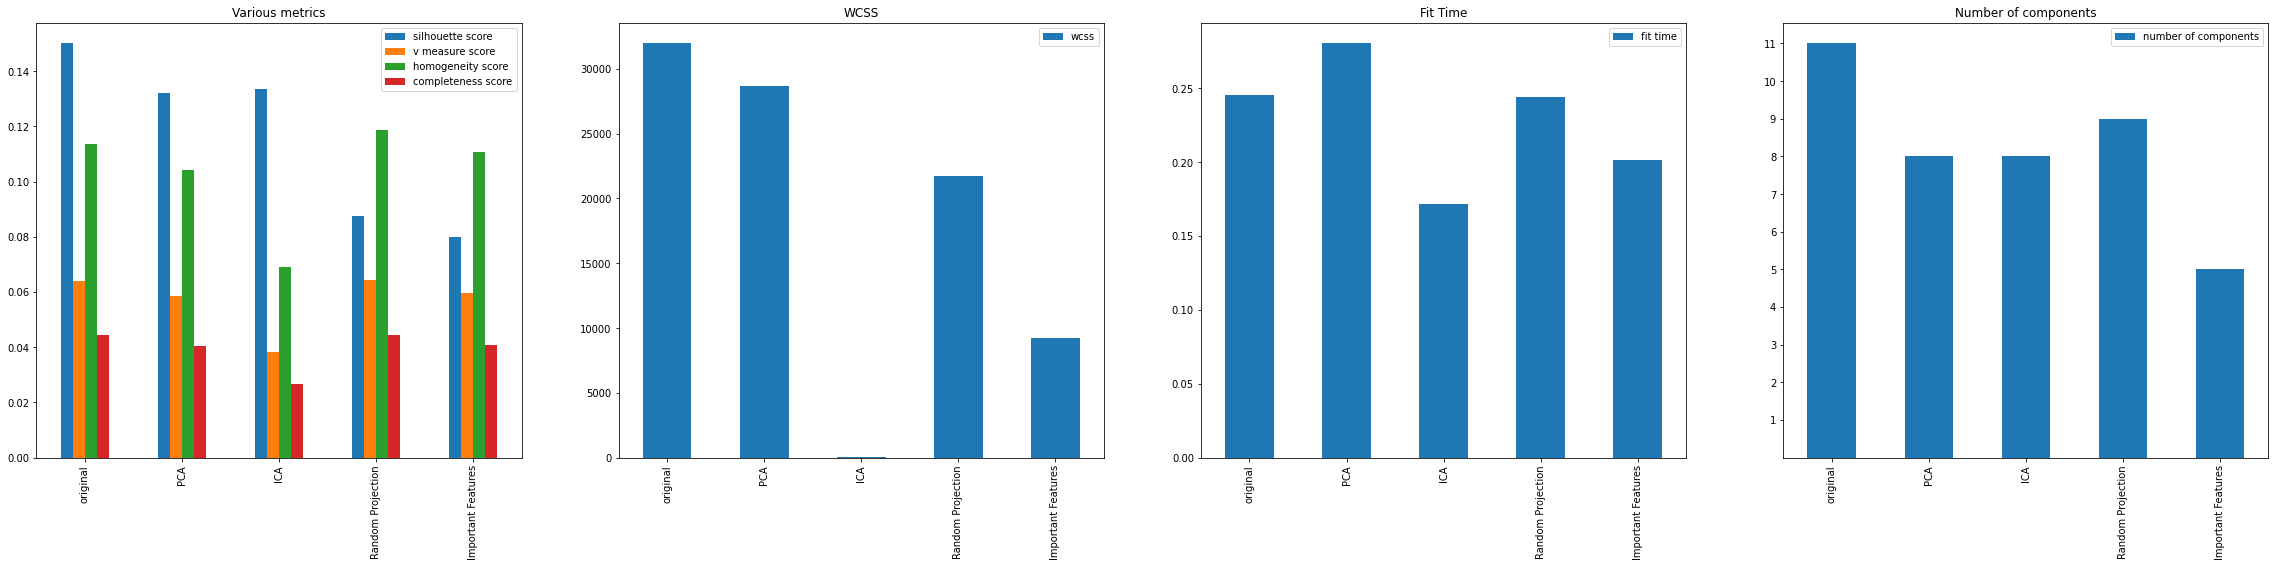

In [349]:

fig, ax = plt.subplots(1, 4, figsize=(40, 8))
kmeans_metrics.plot.bar(y=['silhouette score', 'v measure score', 'homogeneity score', 'completeness score'], ax=ax[0], title='Various metrics')
kmeans_metrics.plot.bar(y='wcss', ax=ax[1], title='WCSS')
kmeans_metrics.plot.bar(y='fit time', ax=ax[2], title='Fit Time')
ax[3].set_yticks(range(1, kmeans_metrics['number of components'].max() + 1))
kmeans_metrics.plot.bar(y='number of components', ax=ax[3], title='Number of components')
plt.show()

Then, I performed the same experiment using Expectation Maximization instead o kMeans.

In [365]:
from sklearn.decomposition import FastICA, PCA
from sklearn.random_projection import SparseRandomProjection

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
pca_features = pca.fit_transform(features)
ica = FastICA(n_components=ICA_COMPONENTS, whiten=True, random_state=42)
ica_features = ica.fit_transform(features)
rp = SparseRandomProjection(
    n_components=RANDOM_PROJECTION_COMPONENTS, random_state=42)
rp_features = rp.fit_transform(features)
important_features = features[ENSEMBLE_IMPORTANT_FEATURES].values

transformed_features_list = [features.values, pca_features,
                             ica_features, rp_features, important_features]

feature_count = [len(f[0]) for f in transformed_features_list]
fit_time = np.zeros(len(transformed_features_list))
bic = []
v_measure_score = []
silhouette_score = []
homogeneity_score = []
completeness_score = []
TIME_TESTS = 20
progress_bar = tqdm(total=len(transformed_features_list) * TIME_TESTS)
em_clustering_labels = []
for iteration in range(TIME_TESTS):
    for index, transformed_features in enumerate(transformed_features_list):
        em = GaussianMixture(n_components=EM_CLUSTERS,
                        covariance_type=EM_COVARIANCE_TYPE, random_state=42)
        t0 = time()
        em.fit(transformed_features)
        labels_ = em.predict(transformed_features)
        em_clustering_labels.append(labels_)
        fit_time[index] += time() - t0
        if iteration == 0:
            bic.append(em.bic(transformed_features))
            silhouette_score.append(metrics.silhouette_score(features,
                                                                labels_,
                                                                metric="euclidean",
                                                                sample_size=300))
            v_measure_score.append(metrics.v_measure_score(
                labels_2, labels_))

            homogeneity_score.append(metrics.homogeneity_score(
                labels_2, labels_))

            completeness_score.append(metrics.completeness_score(
                labels_2, labels_))
        progress_bar.update(1)

fit_time = np.divide(fit_time, TIME_TESTS)


  0%|          | 0/100 [00:00<?, ?it/s]

In [366]:
em_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'bic': bic,
        'silhouette score': silhouette_score,
        'v measure score': v_measure_score,
        'homogeneity score': homogeneity_score,
        'completeness score': completeness_score,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
em_metrics

,number of components,fit time,bic,silhouette score,v measure score,homogeneity score,completeness score
original,11,0.450853,111523.712977,0.019961,0.049844,0.095738,0.033693
PCA,8,0.358692,105729.835816,0.045781,0.048205,0.094430,0.032362
ICA,8,0.393544,-232139.016077,0.060322,0.055580,0.106819,0.037562
Random Projection,9,0.341247,27882.660059,0.040338,0.058526,0.110314,0.039828
Important Features,5,0.232740,47584.151565,0.037834,0.057044,0.101128,0.039726


Here the results were a bit different. "Decision Tree" dimensionality reduction had again very good classification scores against the real labels (compared to pca, ica and random projection), as well as variance. However, it had a negative silhouette score, making it the worse option based on that metric.

ICA seems to be the ultimate winner when it comes to BIC but the fact that it is that negative makes me wonder whether there is a mistake. However, even if there is a scaling issue, the fact that it is negative makes it the winner for the lowest BIC. However, I am not sure that I understand it. Expectation Maximization using Gaussian Mixture supposes that the clusters are generated by a Gaussian distribution. However, ICA supposes that the signals are not Gaussian. Given these assumptions, I would expect that if ICA succeeds to separate the features into independent components, this would mean that EM would fail to classify them properly.

In terms of performance, it seems that the few componetns of Decision Trees dominated the fit times, achieving much lower times.

Also PCA performed much better than the case of kMeans. I cannot explain this at all.

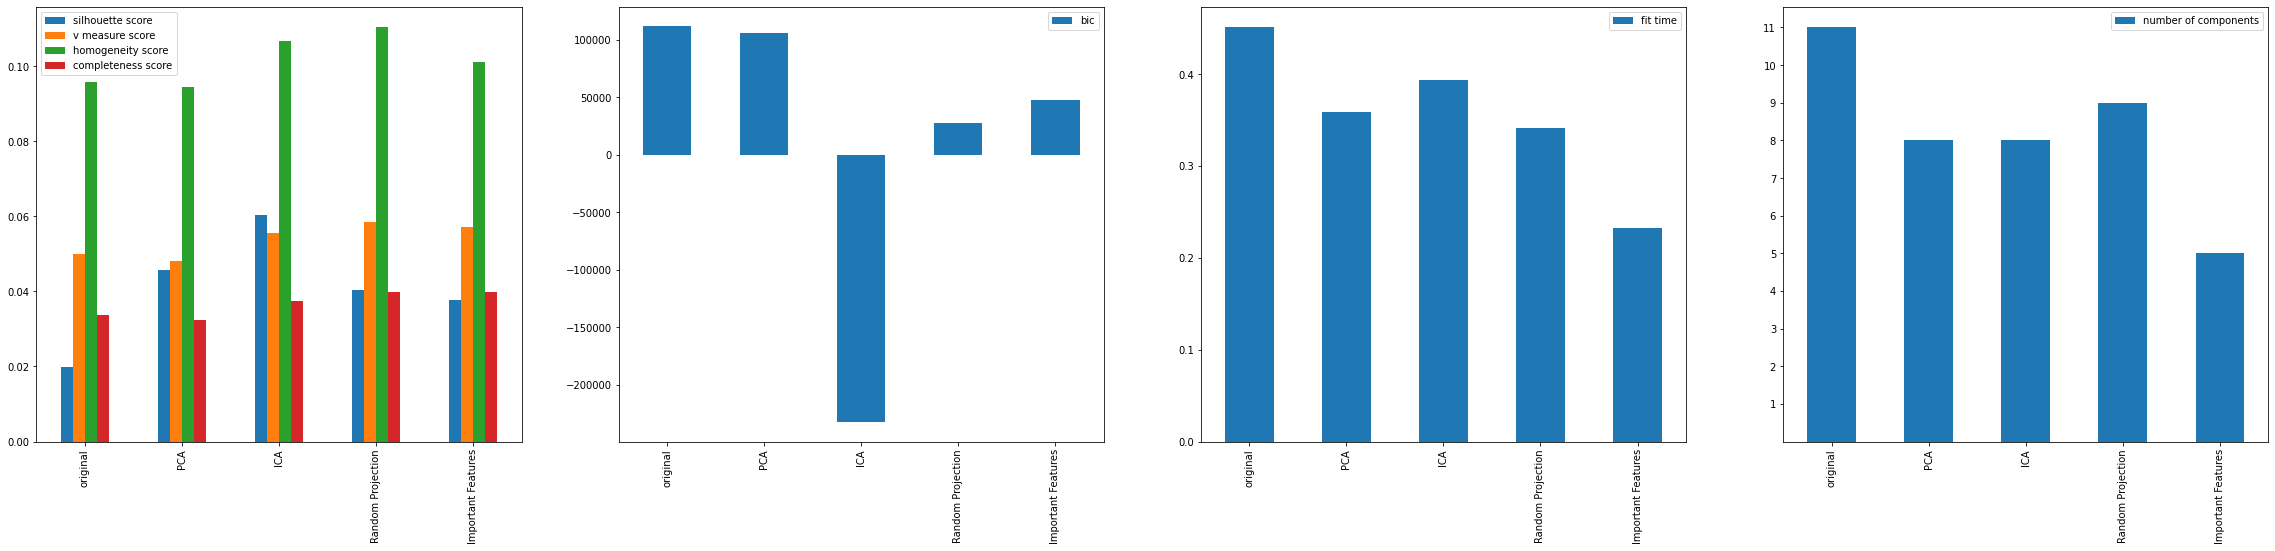

In [367]:

fig, ax = plt.subplots(1, 4, figsize=(40, 8))
em_metrics.plot.bar(y=['silhouette score', 'v measure score', 'homogeneity score', 'completeness score'], ax=ax[0])
em_metrics.plot.bar(y='bic', ax=ax[1])
em_metrics.plot.bar(y='fit time', ax=ax[2])
ax[3].set_yticks(range(1, em_metrics['number of components'].max() + 1))
em_metrics.plot.bar(y='number of components', ax=ax[3])
plt.show()

In order to examine the impact of dimensionality reduction, I also re-run the Neural Network Classifier from Homework 1, using the reduced dimensions.

In [368]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))   


In [369]:
neural_network_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,3.263054,0.983372,0.803401
PCA,8,3.383291,0.946616,0.793197
ICA,8,4.558066,0.799300,0.763265
Random Projection,9,4.129746,0.961785,0.776871
Important Features,5,4.919079,0.899942,0.768707


Dimensionality reduction did not seem to have any impact on accuracy on tesitng data. All algorithms performed the same. However, it played a role in the accuracy in the training set as well as in the time the network needed to convert.

Although Decision Tree dimensionality reducion used the fewest features, it did not help the network converge quickly and thus it had the worse training time. Most probably the infomration of the 5 features wasn't enough for the network to converge quickly. The same picture was true for Random projections.

On the other hand, the reduced dimensions by PCA and ICA played a positive role on performance.

Up to this point of the analysis, I believed that ICA did not found any interesting independednt components in the data, because it did not have any impact on the clustering algorithms. However, the performance of the neural network made me change my mind. When I trained the network using ICA components, I got the same accuracy on testing set as the rest of the algorithms, but much worse performance in the training set. In fact, the accuracy was the same on both test and training sets. This made me think that ICA did find some interesting characteristics in the dataset. 
Why? Because it is clear that the network did not overfit the training data, as the accuracy was limited. Most probably it underfitted the training data. However, the characteristics that ICA tought to the network were enough for the network to be able to achieve the same accuracy as in the other cases.

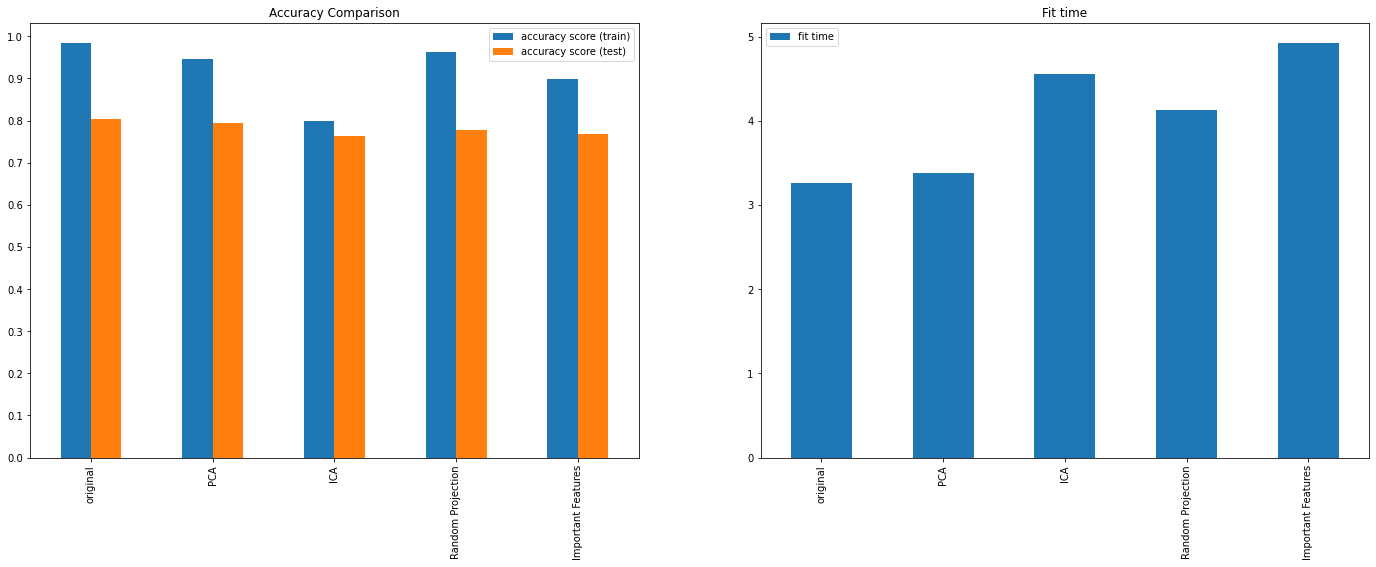

In [390]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0], title='Accuracy Comparison')
neural_network_metrics.plot.bar(y='fit time', ax=ax[1], title='Fit time')
# ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
# neural_network_metrics.plot.bar(y='number of components', ax=ax[2], title='Number of Components')
plt.show()

Last but not least, I performed one last experiment: apart from just giving the network the reduced dimensions, I also included the labels that the classifiers produced as features.

In [391]:
transformed_features_list = [pd.DataFrame(transformed_features) for transformed_features in transformed_features_list]
for transformed_features, labels in zip(transformed_features_list, kmeans_clustering_labels):
    transformed_features['k-means clustering labels'] = labels
transformed_features_list = [transformed_features.values for transformed_features in transformed_features_list]


In [392]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))  

In [393]:
neural_network_with_kmeans_labels_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_with_kmeans_labels_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,2.762257,0.948366,0.779592
PCA,8,1.817608,0.932030,0.776871
ICA,8,1.656865,0.744457,0.743537
Random Projection,9,3.704644,0.914236,0.771429
Important Features,5,6.735148,0.870770,0.755102


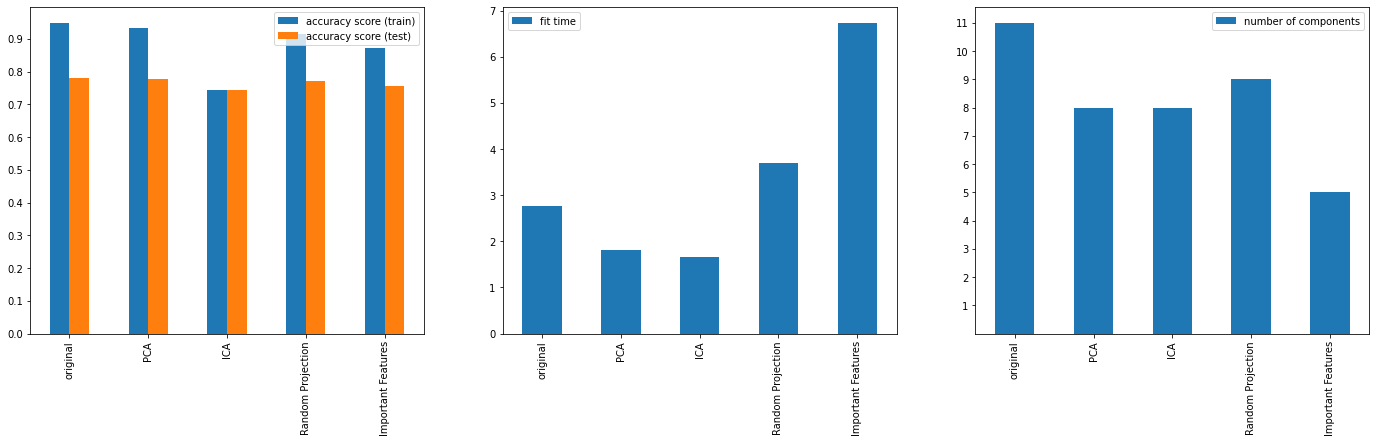

In [394]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
ax[0].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_with_kmeans_labels_metrics.plot.bar(y=['accuracy score (train)', 'accuracy score (test)'], ax=ax[0])
neural_network_with_kmeans_labels_metrics.plot.bar(y='fit time', ax=ax[1])
ax[2].set_yticks(range(1, neural_network_metrics['number of components'].max() + 1))
neural_network_with_kmeans_labels_metrics.plot.bar(y='number of components', ax=ax[2])
plt.show()

In [395]:
transformed_features_list = [pd.DataFrame(transformed_features) for transformed_features in transformed_features_list]
for transformed_features, labels in zip(transformed_features_list, em_clustering_labels):
    transformed_features['em clustering labels'] = labels
transformed_features_list = [transformed_features.values for transformed_features in transformed_features_list]

In [396]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

transformed_features_split = [
    train_test_split(transformed_features, labels_2,
                     test_size=0.3, random_state=42)
    for transformed_features in transformed_features_list
]
accuracy_score_train = []
accuracy_score_test = []
fit_time = []
for (x_train, x_test, y_train, y_test) in transformed_features_split:
    neural_network = MLPClassifier(
        hidden_layer_sizes=(40, 80),
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        random_state=42
    )
    t0 = time()
    neural_network.fit(x_train, y_train)
    fit_time.append(time() - t0)
    
    accuracy_score_train.append(accuracy_score(y_train, neural_network.predict(x_train)))
    accuracy_score_test.append(accuracy_score(y_test, neural_network.predict(x_test)))  

In [397]:
neural_network_with_em_labels_metrics = pd.DataFrame(
    {
        'number of components': feature_count,
        'fit time': fit_time,
        'accuracy score (train)': accuracy_score_train,
        'accuracy score (test)': accuracy_score_test,
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features'])
neural_network_with_em_labels_metrics

,number of components,fit time,accuracy score (train),accuracy score (test)
original,11,2.678609,0.929697,0.773469
PCA,8,2.799738,0.950408,0.779592
ICA,8,0.779519,0.732497,0.736735
Random Projection,9,4.192716,0.938156,0.775510
Important Features,5,3.253703,0.837515,0.768027


In [398]:
neural_network_comparison = pd.DataFrame(
    {
        'fit time': neural_network_metrics['fit time'],
        'fit time - k-means labels': neural_network_with_kmeans_labels_metrics['fit time'],
        'fit time - em labels': neural_network_with_em_labels_metrics['fit time'],
        'accuracy score (train)': neural_network_metrics['accuracy score (train)'],
        'accuracy score (train) - k-means labels': neural_network_with_kmeans_labels_metrics['accuracy score (train)'],
        'accuracy score (train) - em labels': neural_network_with_em_labels_metrics['accuracy score (train)'],
        'accuracy score (test)': neural_network_metrics['accuracy score (test)'],
        'accuracy score (test) - k-means labels': neural_network_with_kmeans_labels_metrics['accuracy score (test)'],
        'accuracy score (test) - em labels': neural_network_with_em_labels_metrics['accuracy score (test)']
    },
    index=['original', 'PCA', 'ICA', 'Random Projection', 'Important Features']
)
neural_network_comparison


,fit time,fit time - k-means labels,fit time - em labels,accuracy score (train),accuracy score (train) - k-means labels,accuracy score (train) - em labels,accuracy score (test),accuracy score (test) - k-means labels,accuracy score (test) - em labels
original,3.263054,2.762257,2.678609,0.983372,0.948366,0.929697,0.803401,0.779592,0.773469
PCA,3.383291,1.817608,2.799738,0.946616,0.932030,0.950408,0.793197,0.776871,0.779592
ICA,4.558066,1.656865,0.779519,0.799300,0.744457,0.732497,0.763265,0.743537,0.736735
Random Projection,4.129746,3.704644,4.192716,0.961785,0.914236,0.938156,0.776871,0.771429,0.775510
Important Features,4.919079,6.735148,3.253703,0.899942,0.870770,0.837515,0.768707,0.755102,0.768027


So is providing the cluster labels as features to the neural network improves perfomrance? 

If clustering is correct, I would expect that the extra information that the clustering algorithms extracted from the data would benefit the neural netowrk.

However, this is not the case. Providing cluster labels as features did not have any positive impact on network accuracy. The differences in accuracies are too small to judge whether the labels played a negative or positive role.

However, they had an impact on performance. It seems that the labels provided by Expectation Maximization "confused" the network resulting to longer training times. This is inline with my previous conclusion that EM failed to classify the wines.

kMeans labels seem to have a positive impact on training time. Although the clustering information did not help the network increase it's accuracy, it provided some hint that made the network converge faster.

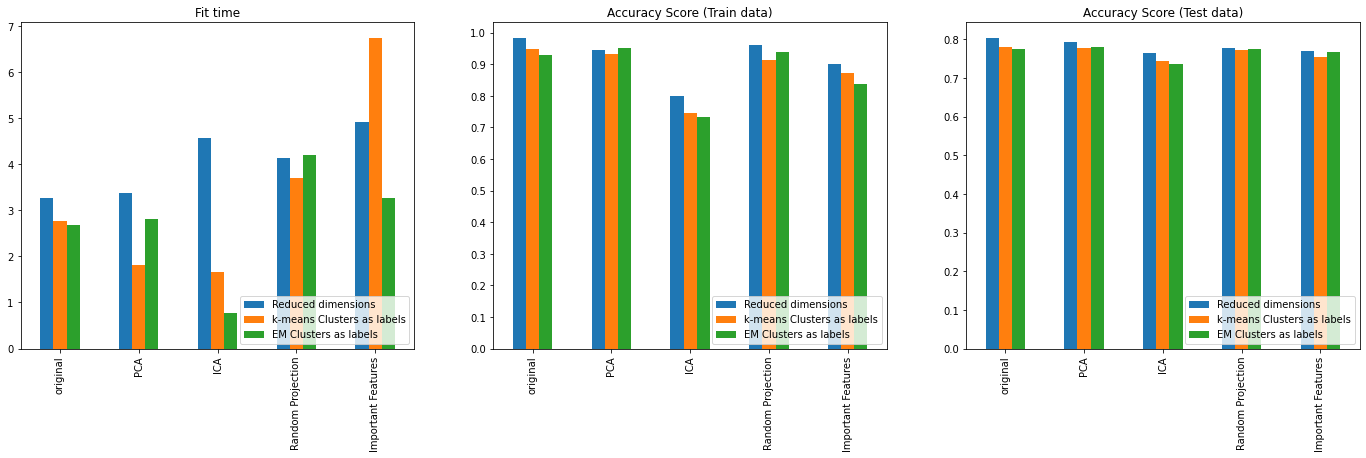

In [399]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
neural_network_comparison.plot.bar(y=['fit time', 'fit time - k-means labels', 'fit time - em labels'], ax=ax[0], title='Fit time')
ax[0].legend(['Reduced dimensions', 'k-means Clusters as labels', 'EM Clusters as labels'], loc=4)
ax[1].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (train)', 'accuracy score (train) - k-means labels', 'accuracy score (train) - em labels'], ax=ax[1], title='Accuracy Score (Train data)')
ax[1].legend(['Reduced dimensions', 'k-means Clusters as labels', 'EM Clusters as labels'], loc=4)
ax[2].set_yticks(np.arange(0.0, 1.1, 0.1))
neural_network_comparison.plot.bar(y=['accuracy score (test)', 'accuracy score (test) - k-means labels', 'accuracy score (test) - em labels'], ax=ax[2], title='Accuracy Score (Test data)')
ax[2].legend(['Reduced dimensions', 'k-means Clusters as labels', 'EM Clusters as labels'], loc=4)
plt.show()

References:
- Arthur, D. and Vassilvitskii, S. “k-means++: the advantages of careful seeding: https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf